In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Loading the MNIST dataset

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# Visualizing some random instances

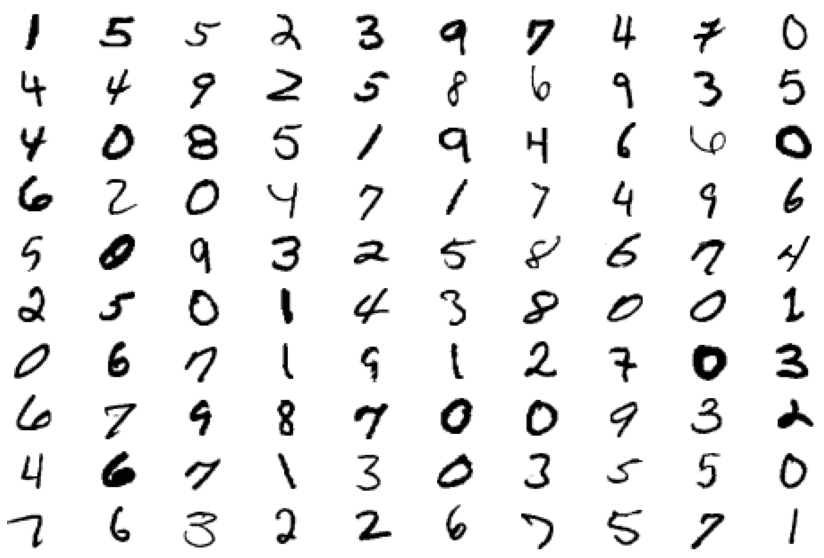

In [3]:
num_rows = 10
num_cols = 10
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(15)
fig.set_figheight(10)
for row in range(num_rows):
    for col in range(num_cols):
        index = np.random.randint(0, X_train.shape[0])
        axs[row, col].imshow(X_train[index], cmap = "binary")
        axs[row, col].axis("off")
plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
plt.show()

# Splitting and normalizing the dataset

In [4]:
X_train, X_valid = X_train[:55000] / 255.0, X_train[55000:] / 255.0
y_train, y_valid = y_train[:55000], y_train[55000:]
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((55000, 28, 28), (55000,), (5000, 28, 28), (5000,))

In [5]:
X_test = X_test / 255.0

In [6]:
X_train.min(), X_train.max(), X_valid.min(), X_valid.max(), X_test.min(), X_test.max()

(0.0, 1.0, 0.0, 1.0, 0.0, 1.0)

In [7]:
y_train.min(), y_train.max(), y_valid.min(), y_valid.max(), y_test.min(), y_test.max()

(0, 9, 0, 9, 0, 9)

# Autoencoder to get latent representations of data

In [8]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(128, activation = "selu", kernel_initializer = "lecun_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation = "selu", kernel_initializer = "lecun_normal")
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
Total params: 104,608
Trainable params: 104,608
Non-trainable params: 0
_________________________________________________________________


In [9]:
decoder = keras.models.Sequential([
    keras.layers.Dense(128, activation = "selu", kernel_initializer = "lecun_normal", input_shape = [32]),
    keras.layers.Dense(28*28, activation = "sigmoid", kernel_initializer = "glorot_normal"),
    keras.layers.Reshape([28, 28])
])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 105,360
Trainable params: 105,360
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32)                104608    
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            105360    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [11]:
autoencoder.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate = 0.005))

In [12]:
history = autoencoder.fit(
    X_train, X_train, epochs = 100, validation_data = (X_valid, X_valid),
    callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)]
)

Epoch 1/100
1719/1719 [==============================] - 23s 8ms/step - loss: 0.1562 - val_loss: 0.1063
Epoch 2/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1142 - val_loss: 0.1033
Epoch 3/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1128 - val_loss: 0.1020
Epoch 4/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1116 - val_loss: 0.1058
Epoch 5/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1117 - val_loss: 0.1019
Epoch 6/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1095 - val_loss: 0.1011
Epoch 7/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1092 - val_loss: 0.1018
Epoch 8/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1086 - val_loss: 0.1001
Epoch 9/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1084 - val_loss: 0.1006
Epoch 10/100
1719/1719 [==============================] - 8s 5ms/step - 

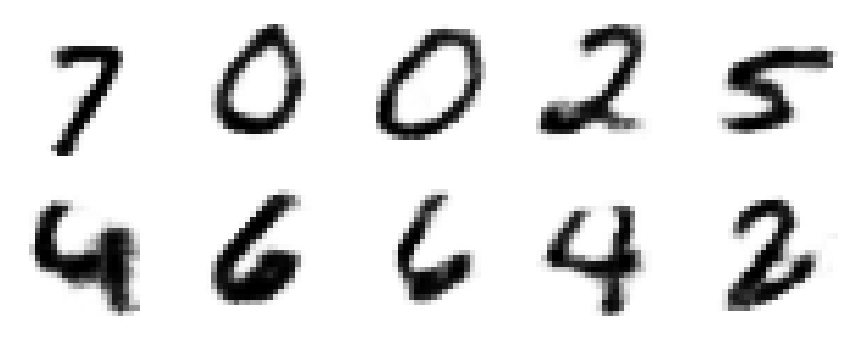

In [13]:
num_rows = 2
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figwidth(15)
fig.set_figheight(6)
ae_outputs = autoencoder.predict(X_valid)
for row in range(num_rows):
    for col in range(num_cols):
        index = np.random.randint(0, X_valid.shape[0])
        axs[row, col].imshow(ae_outputs[index], cmap = "binary")
        axs[row, col].axis("off")
plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
plt.show()

# t-SNE for dimensionality reduction

In [14]:
from sklearn.manifold import TSNE

In [15]:
data_32D = encoder.predict(X_valid)
tsne = TSNE()
data_2D = tsne.fit_transform(data_32D)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [17]:
data_viz = np.concatenate((data_2D, y_valid.reshape(len(y_valid), 1)), axis = 1)
data_viz = pd.DataFrame(data_viz, columns = ["dim1", "dim2", "y"])
data_viz.head(5)

,dim1,dim2,y
0,-17.709246,70.637421,1.0
1,-74.231125,-15.882264,2.0
2,-12.689473,3.835941,8.0
3,18.154255,66.083595,7.0
4,49.270363,13.049009,4.0


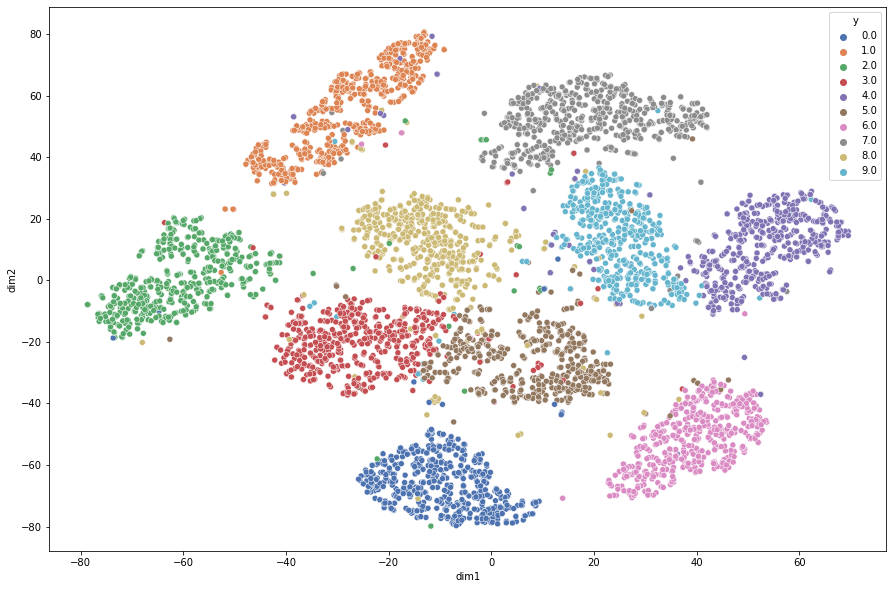

In [18]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = data_viz, x = "dim1", y = "dim2", hue = "y", palette = "deep")
plt.show()

In [20]:
%store X_train y_train X_valid y_valid X_test y_test

Stored 'X_train' (ndarray)
Stored 'y_train' (ndarray)
Stored 'X_valid' (ndarray)
Stored 'y_valid' (ndarray)
Stored 'X_test' (ndarray)
Stored 'y_test' (ndarray)
